# The problem to be solved: create a Machine Learning model to predict the occurrence of diseases

Data source: National Institute of Diabetes and Digestive and Kidney Diseases

Competition page: https://www.kaggle.com/c/competicao-dsa-machine-learning-jan-2019/

# Exploratory Data Analysis 

Data fields:
* num_gestacoes - Number of times pregnant
* glicose - Plasma glucose concentration in oral glucose tolerance test
* pressao_sanguinea - Diastolic blood pressure in mm Hg
* grossura_pele - Thickness of the triceps skin fold in mm
* insulina - Insulin (mu U / ml)
* bmi - Body mass index measured by weight in kg / (height in m) ^ 2
* indice_historico - Diabetes History Index (Pedigree Function)
* idade - Age in years
* classe - Class (0 - did not develop disease / 1 - developed disease)

## Loading the data

In [1]:
# Importing packages
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

# Loading the data
data = pd.read_csv('data/dataset_treino.csv')
test_data = pd.read_csv('data/dataset_teste.csv')
data.head(5)

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


## Data overview

In [2]:
# General statistics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
id                   600 non-null int64
num_gestacoes        600 non-null int64
glicose              600 non-null int64
pressao_sanguinea    600 non-null int64
grossura_pele        600 non-null int64
insulina             600 non-null int64
bmi                  600 non-null float64
indice_historico     600 non-null float64
idade                600 non-null int64
classe               600 non-null int64
dtypes: float64(2), int64(8)
memory usage: 47.0 KB


All 10 predictors variables (features) are quantitative (numerical) and we have 600 observations to build the prediction model.

The only qualitative column is the labels, where:

* 0 - do not have the disease
* 1 - have the disease


## Data Cleaning

### Checking if there is missing values

In [3]:
# If the result is False, there is no missing value
data.isnull().values.any()

False

### Computing statistics for each column

In [4]:
data.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,300.500000,3.820000,120.135000,68.681667,20.558333,79.528333,31.905333,0.481063,33.278333,0.346667
std,173.349358,3.362009,32.658246,19.360226,16.004588,116.490583,8.009638,0.337284,11.822315,0.476306
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,150.750000,1.000000,99.000000,64.000000,0.000000,0.000000,27.075000,0.248000,24.000000,0.000000
50%,300.500000,3.000000,116.000000,70.000000,23.000000,36.500000,32.000000,0.384000,29.000000,0.000000
75%,450.250000,6.000000,140.000000,80.000000,32.000000,122.750000,36.525000,0.647000,40.000000,1.000000
max,600.000000,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From the table above, we can see the zero values in almost all columns.
For some of these columns, zero makes sense, like for Pregnancies and Outcome. But for some of the others, like BloodPressure or BMI, zero definitely doesn't make sense. 

After read some papers about the variables in the dataset, I see that some columns can have a value very close to zero (e.g. *grossura_pele*), but others can't have a zero value. 

The columns that can not have a zero value. 
* glicose
* pressao_sanguinea
* bmi

Let's see the number of the occurrences of zero values for all columns:

In [5]:
# Compute the number of occurrences of a zero value 
features = ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi', 'indice_historico', 'idade']
for c in features:
    counter = len(data[data[c] == 0])    
    print('{} - {}'.format(c, counter))    

num_gestacoes - 93
glicose - 5
pressao_sanguinea - 28
grossura_pele - 175
insulina - 289
bmi - 9
indice_historico - 0
idade - 0


We can also see that the column *insulina* has 289 values, wich correspond to 48% of the training data.

Let's remove these observations from the selected columns.

In [6]:
# Removing observations with zero value
data_cleaned = data.copy()   
for c in ['glicose', 'pressao_sanguinea', 'bmi']:
    data_cleaned = data_cleaned[data_cleaned[c] != 0]

data_cleaned.shape

(564, 10)

The final number of observations was 564. 

Let's see the compute some statistics again:

In [7]:
data_cleaned.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,300.664894,3.845745,121.354610,72.049645,21.432624,84.406028,32.367199,0.483294,33.448582,0.340426
std,173.410435,3.349287,31.130992,12.261552,15.809953,118.432015,6.974710,0.337668,11.868844,0.474273
min,1.000000,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,150.750000,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.250500,24.000000,0.000000
50%,298.500000,3.000000,116.000000,72.000000,23.500000,49.000000,32.000000,0.389000,29.000000,0.000000
75%,450.250000,6.000000,141.250000,80.000000,33.000000,130.000000,36.600000,0.648250,41.000000,1.000000
max,600.000000,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Checking outliers

Let's check if there is ouliers in the data.

First, we'll use a set of boxplots, one for each column.

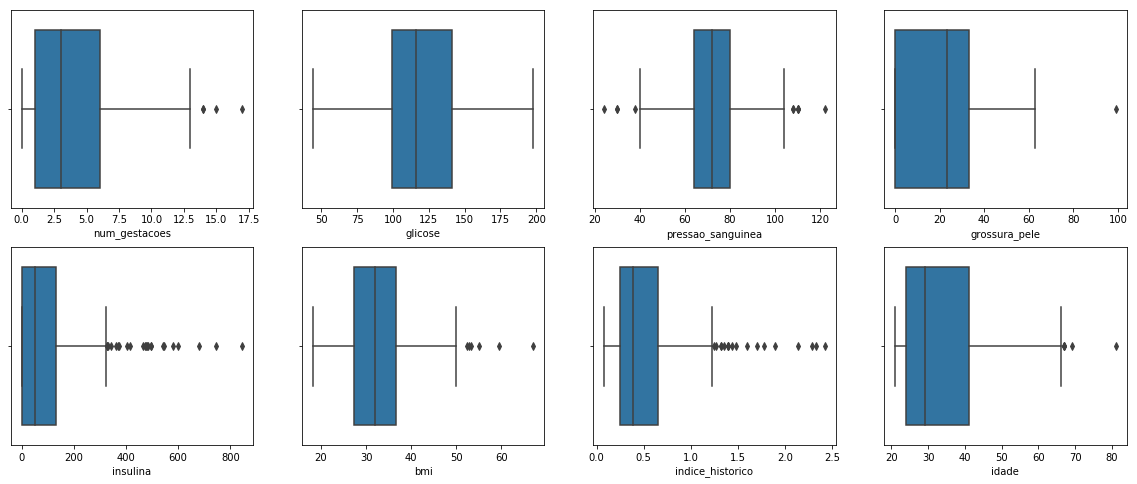

In [8]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

x,y = 0,0
for i, column in enumerate(data_cleaned.columns[1:-1]):    
    sns.boxplot(x=data_cleaned[column], ax=axes[x,y])
    if i < 3:
        y += 1
    elif i == 3: 
        x = 1
        y = 0
    else:
        y += 1

We can see some possible outliers for almost all columns (separated points in the plots).

The outliers can either be a mistake or just variance. For now, let's consider all of than as a mistakes.

To remove these outliers we can use Z-Score or IQR (Interquartile Range).

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1. While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

Let's use Z-score function defined in scipy library to detect the outliers:

In [9]:
# Compute the Z-Score for each columns

print(data_cleaned.shape)

z = np.abs(stats.zscore(data_cleaned))    
data_cleaned = data_cleaned[(z < 3).all(axis=1)]   

print(data_cleaned.shape)    

(564, 10)
(531, 10)


Using Z-Score, 33 observations where removed.

Let's see the boxplots again:

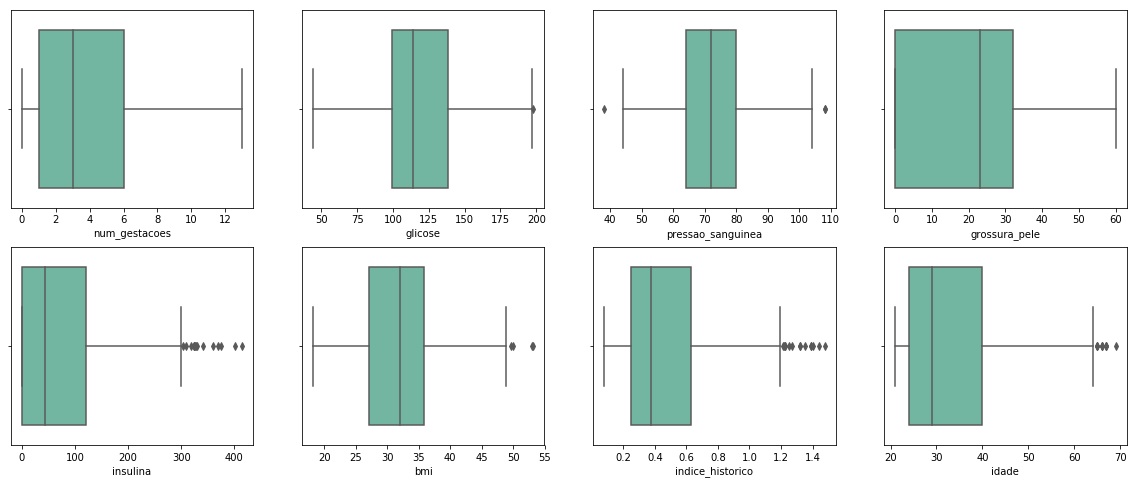

In [10]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

x,y = 0,0
for i, column in enumerate(data_cleaned.columns[1:-1]):    
    sns.boxplot(x=data_cleaned[column], ax=axes[x,y], palette="Set2")
    if i < 3:
        y += 1
    elif i == 3: 
        x = 1
        y = 0
    else:
        y += 1

The data was much cleaner now. Still, there are some points in the boxplots, but some of them are not outliers, like the *insulina* values higher than 400, which is acceptable in people with diabetes. 

### Checking the balance of the dataset

Let's checking the distribuitions of examples for each label:

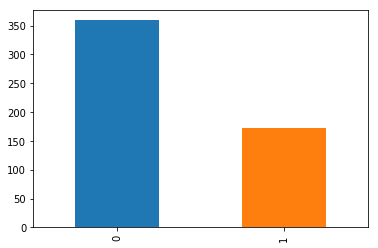

In [11]:
data_cleaned.classe.value_counts().plot(kind='bar');

In [12]:
data_cleaned.classe.value_counts(normalize=True)

0    0.676083
1    0.323917
Name: classe, dtype: float64

From the figure above, we see most of our examples are of people that do not have the disease. More specifically, 67% of the data are for healthy people.

As the dataset is unbalanced, let's use some methods to reduce the unbalance of the classes.

I use the over-sampling SMOTE method.
SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.


187 new random picked points


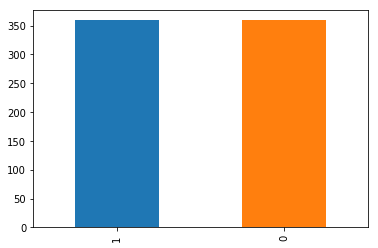

In [13]:
from imblearn.over_sampling import SMOTE

# Select the columns with features
features = ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi', 'indice_historico', 'idade']
X = data_cleaned[features]
# Select the columns with labels
Y = data_cleaned['classe']

smote = SMOTE(sampling_strategy=1.0, k_neighbors=4)
X_sm, y_sm = smote.fit_sample(X, Y)

print(X_sm.shape[0] - X.shape[0], 'new random picked points')
data_cleaned_oversampled = pd.DataFrame(X_sm, columns=data.columns[1:-1])
data_cleaned_oversampled['classe'] = y_sm
data_cleaned_oversampled['id'] = range(1,len(y_sm)+1)

for c in ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'idade']:
    data_cleaned_oversampled[c] = data_cleaned_oversampled[c].apply(lambda x: int(x))

data_cleaned_oversampled.classe.value_counts().plot(kind='bar');

# Training the Model

Now that data is cleaned, let's use a machine learning model to predict whether or not a person has diabetes.

The metric used in this competition is the **accuracy score**.

### Using Decision Tree

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

# Select the columns with features
features = ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi', 'indice_historico', 'idade']
X = data_cleaned_oversampled[features]
# Select the columns with labels
Y = data_cleaned_oversampled['classe']

# Perform the training and test 100 times with different seeds and compute the mean accuracy.
# Save results
acurrances = []
for i in range(100):    
    # Spliting Dataset into Test and Train
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)

    # Create and train the model
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=i, max_depth=4)
    clf.fit(X_train,y_train)

    # Performing predictions with test dataset
    y_pred = clf.predict(X_test)
    # Computing accuracy    
    acurrances.append(accuracy_score(y_test, y_pred)*100)

print('Accuracy is ', np.mean(acurrances))

Accuracy is  73.35648148148148


### Using Logistic Regression (LR)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Select the columns with features
features = ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi', 'indice_historico', 'idade']

# For the LR the oversampled database decreased the model accuracy, so I choose do not use it.
X = data_cleaned[features]
# Select the columns with labels
Y = data_cleaned['classe']

# Perform the training and test 100 times with different seeds and compute the mean accuracy.
# Save results
acurrances = []
for i in range(100):    
    # Spliting the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
    LR_model=LogisticRegression(class_weight={1:1.15})
    LR_model.fit(X_train,y_train)

    # Testing
    y_pred=LR_model.predict(X_test)
    acurrances.append(accuracy_score(y_test, y_pred)*100)
    
    # Print only the last
    if i == 99:
        pass
        #print(classification_report(y_test,y_pred))
        #print(confusion_matrix(y_true=y_test, y_pred=y_pred))

print('Accuracy is ', np.mean(acurrances))

Accuracy is  76.725


### Feature selection

The large number of zero values in the *grossura_pele* and *insulina* are impairing the performance of the model.
So, as insulin is an important parameter in the evaluation of diabetes let's replace the zeros values by the mean
for both columns.

As the Logistic Regression (LR) perform better than the Decision Tree. I'll use only LR from now.

In [16]:
# Replacing the zeros by the mean
data_cleaned_no_zeros = data_cleaned.copy()

for c in ['grossura_pele', 'insulina']:    
    feature_avg =data_cleaned[data_cleaned[c]>0][[c]].mean()
    data_cleaned[c]=np.where(data_cleaned[[c]]!=0,data_cleaned[[c]],feature_avg)

In [17]:
# Select the columns with features
features = ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi', 'indice_historico', 'idade']
X = data_cleaned_no_zeros[features]
# Select the columns with labels
Y = data_cleaned_no_zeros['classe']

# Perform the training and test 100 times with different seeds and compute the mean accuracy score.
# Save results
acurrances = []
for i in range(100):    
    # Spliting the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
    LR_model=LogisticRegression(class_weight={1:1.1})
    LR_model.fit(X_train,y_train)

    # Testing
    y_pred=LR_model.predict(X_test)
    acurrances.append(accuracy_score(y_test, y_pred)*100)
    
    # Print only the last
    if i == 99:
        print(classification_report(y_test,y_pred))
        print(confusion_matrix(y_true=y_test, y_pred=y_pred))

print('Accuracy is ', np.mean(acurrances))


              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.75      0.60      0.67        50

   micro avg       0.81      0.81      0.81       160
   macro avg       0.79      0.75      0.77       160
weighted avg       0.81      0.81      0.81       160

[[100  10]
 [ 20  30]]
Accuracy is  76.5625


The performance decrease when I replace the zeros values by the mean for *grossura_pele* and *insulina* columns.



## Performing the Final Prediction

For the final model, I choose to use LR with the cleaned dataset.

In [18]:
# Create and train the model with all data
model=LogisticRegression(class_weight={1:1.1})
model.fit(data_cleaned[features],data_cleaned['classe'])

# Get the kaggle test data
X_test = test_data[features]
# Make the prediction 
prediction = model.predict(X_test)

# Add the predictions to the dataframe 
test_data['classe'] = prediction

# Create the submission file
test_data.loc[:,['id', 'classe']].to_csv('submission.csv', encoding='utf-8', index=False)

#### For this submission I got a accuracy/score of 76.27%.